In [ ]:
<h1>Montecarlo</h1>
<h2>MC Estimate of state</h2>
<h4>First visit and Every visit</h4>



In [1]:
#Monte Carlo First-Visit Value Estimation
#📘 Environment: Random Walk
#	•	States: A (1), B (2), C (3), D (4), E (5)
#	•	Start in state C (state 3)
#	•	Move left or right randomly
#	•	Terminal states: left of A (state 0), right of E (state 6)
#	•	Reward: +1 for reaching right terminal state (6), 0 otherwise
import numpy as np
import random
from collections import defaultdict

# Parameters
gamma = 1.0
num_episodes = 10000
states = [1, 2, 3, 4, 5]  # States A-E (state 3 is start)
start_state = 3

def generate_episode():
    state = start_state
    episode = []
    while True:
        action = random.choice([-1, 1])  # move left or right
        next_state = state + action
        reward = 0

        if next_state == 6:
            reward = 1
            episode.append((state, action, reward))
            break
        elif next_state == 0:
            reward = 0
            episode.append((state, action, reward))
            break
        else:
            episode.append((state, action, reward))
            state = next_state
    return episode

# Monte Carlo Prediction (First-Visit)
V = defaultdict(float)
returns = defaultdict(list)

for _ in range(num_episodes):
    episode = generate_episode()
    G = 0
    visited = set()
    for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = gamma * G + reward
        if state not in visited:
            visited.add(state)
            returns[state].append(G)
            V[state] = np.mean(returns[state])

# Print value function
for s in sorted(states):
    print(f"V({s}) = {V[s]:.3f}")

V(1) = 0.172
V(2) = 0.339
V(3) = 0.503
V(4) = 0.668
V(5) = 0.829


In [2]:
# Every visit MC
import numpy as np
import random
from collections import defaultdict

# Environment parameters
gamma = 1.0
num_episodes = 10000
states = [1, 2, 3, 4, 5]  # Non-terminal states
start_state = 3

def generate_episode():
    state = start_state
    episode = []
    while True:
        action = random.choice([-1, 1])
        next_state = state + action
        reward = 0

        if next_state == 6:
            reward = 1
            episode.append((state, action, reward))
            break
        elif next_state == 0:
            reward = 0
            episode.append((state, action, reward))
            break
        else:
            episode.append((state, action, reward))
            state = next_state
    return episode

# Monte Carlo Prediction (Every-Visit)
V = defaultdict(float)
returns = defaultdict(list)

for _ in range(num_episodes):
    episode = generate_episode()
    G = 0
    state_returns = []

    # Compute return G_t from the end
    for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = reward + gamma * G
        state_returns.insert(0, (state, G))  # Prepend to match forward order

    # For every visit, append G
    for state, G in state_returns:
        returns[state].append(G)
        V[state] = np.mean(returns[state])

# Print value estimates
for s in sorted(states):
    print(f"V({s}) = {V[s]:.3f}")

V(1) = 0.163
V(2) = 0.335
V(3) = 0.498
V(4) = 0.659
V(5) = 0.829


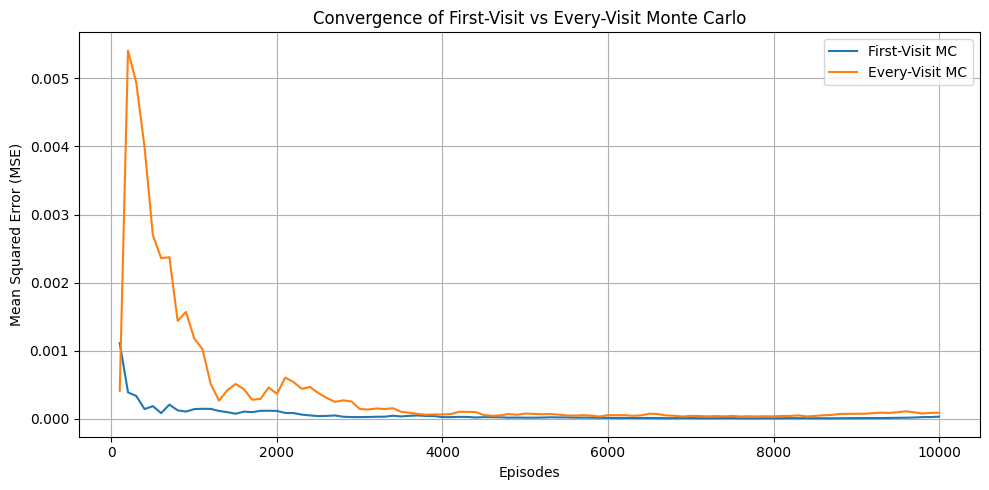

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Environment setup
gamma = 1.0
true_values = {1: 1/6, 2: 2/6, 3: 3/6, 4: 4/6, 5: 5/6}
states = [1, 2, 3, 4, 5]
start_state = 3
num_episodes = 10000
eval_every = 100  # evaluate MSE every this many episodes

def generate_episode():
    state = start_state
    episode = []
    while True:
        action = random.choice([-1, 1])
        next_state = state + action
        reward = 0
        if next_state == 6:
            reward = 1
            episode.append((state, action, reward))
            break
        elif next_state == 0:
            reward = 0
            episode.append((state, action, reward))
            break
        else:
            episode.append((state, action, reward))
            state = next_state
    return episode

# Monte Carlo Prediction
def mc_prediction(first_visit=True):
    V = defaultdict(float)
    returns = defaultdict(list)
    mse = []

    for episode_idx in range(1, num_episodes + 1):
        episode = generate_episode()
        G = 0
        state_returns = []

        # Compute G backwards
        for t in reversed(range(len(episode))):
            state, _, reward = episode[t]
            G = reward + gamma * G
            state_returns.insert(0, (state, G))  # prepend

        visited = set()
        for state, G in state_returns:
            if first_visit and state in visited:
                continue
            returns[state].append(G)
            V[state] = np.mean(returns[state])
            visited.add(state)

        if episode_idx % eval_every == 0:
            mse.append(np.mean([(V[s] - true_values[s]) ** 2 for s in states]))

    return mse

# Run First-Visit and Every-Visit
fv_mse = mc_prediction(first_visit=True)
ev_mse = mc_prediction(first_visit=False)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(np.arange(eval_every, num_episodes + 1, eval_every), fv_mse, label='First-Visit MC')
plt.plot(np.arange(eval_every, num_episodes + 1, eval_every), ev_mse, label='Every-Visit MC')
plt.xlabel('Episodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Convergence of First-Visit vs Every-Visit Monte Carlo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# MonteCarlo ES
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Gridworld configuration
grid_size = (4, 4)
terminal_states = [(0, 0), (3, 3)]
actions = ['U', 'D', 'L', 'R']
action_map = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
gamma = 1.0  # discount factor

# Step function
def step(state, action):
    if state in terminal_states:
        return state, 0  # terminal: no movement, 0 reward
    move = action_map[action]
    next_state = (
        max(0, min(grid_size[0] - 1, state[0] + move[0])),
        max(0, min(grid_size[1] - 1, state[1] + move[1]))
    )
    reward = -1  # each step costs -1
    return next_state, reward

# Generate an episode using Exploring Starts (random (s, a))
def generate_episode(Q):
    all_states = [
        (i, j) for i in range(grid_size[0])
               for j in range(grid_size[1])
               if (i, j) not in terminal_states
    ]
    state = random.choice(all_states)
    action = random.choice(actions)
    episode = [(state, action, 0)]

    while True:
        next_state, reward = step(state, action)
        if next_state in terminal_states:
            episode.append((next_state, None, reward))
            break
        state = next_state
        action = max(Q[state], key=Q[state].get) if state in Q else random.choice(actions)
        episode.append((state, action, reward))
    return episode

# Monte Carlo Control with Exploring Starts
def mc_control_es(num_episodes=10000):
    Q = defaultdict(lambda: {a: 0.0 for a in actions})
    returns = defaultdict(list)
    policy = {}

    for _ in range(num_episodes):
        episode = generate_episode(Q)
        G = 0
        visited = set()
        for t in reversed(range(len(episode) - 1)):
            state, action, _ = episode[t]
            reward = episode[t + 1][2]
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])
                policy[state] = max(Q[state], key=Q[state].get)
    return policy, Q

# Plotting the learned policy
def plot_policy(policy, title="Optimal Policy via Exploring Starts"):
    grid = np.full(grid_size, '.', dtype=object)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            s = (i, j)
            if s in terminal_states:
                grid[i, j] = 'T'
            else:
                grid[i, j] = policy.get(s, '?')
    plt.figure(figsize=(5, 5))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            plt.text(j, grid_size[0] - 1 - i, grid[i, j], ha='center', va='center', fontsize=16)
    plt.xticks(np.arange(grid_size[1]))
    plt.yticks(np.arange(grid_size[0]))
    plt.grid(True)
    plt.title(title)
    plt.show()

# Train and visualize
if __name__ == "__main__":
    policy, Q = mc_control_es(num_episodes=10000)
    plot_policy(policy)


In [ ]:
# Q learning 
# Q-learning implementation
def q_learning(grid_size=(4, 4), alpha=0.1, gamma=1.0, epsilon=0.1, episodes=10000):
    Q = defaultdict(lambda: {a: 0.0 for a in actions})
    policy = {}

    for _ in range(episodes):
        state = random.choice([
            (i, j) for i in range(grid_size[0])
                   for j in range(grid_size[1])
                   if (i, j) not in terminal_states
        ])

        while state not in terminal_states:
            if random.random() < epsilon:
                action = random.choice(actions)
            else:
                action = max(Q[state], key=Q[state].get)

            next_state, reward = step(state, action)
            best_next_action = max(Q[next_state], key=Q[next_state].get)
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state

    for s in Q:
        policy[s] = max(Q[s], key=Q[s].get)

    return policy, Q

In [ ]:
if __name__ == "__main__":
    print("Training Monte Carlo (Exploring Starts)...")
    mc_policy, _ = mc_control_es(num_episodes=10000)
    plot_policy(mc_policy, title="Monte Carlo Policy (Exploring Starts)")

    print("Training Q-learning...")
    ql_policy, _ = q_learning(episodes=10000)
    plot_policy(ql_policy, title="Q-learning Policy")

In [5]:
# everyvisit montecarly blackjack
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Initialize Blackjack environment
env = gym.make('Blackjack-v1', sab=True)  # sab=True gives Sutton-style blackjack

# Define policy: stick if player sum >= 20, else hit
def policy(state):
    player_sum, dealer_card, usable_ace = state
    return 0 if player_sum >= 20 else 1  # 0 = stick, 1 = hit

# Monte Carlo Every-Visit Prediction
def mc_prediction(policy, env, num_episodes=500000, gamma=1.0):
    returns = defaultdict(list)
    V = defaultdict(float)

    for _ in range(num_episodes):
        episode = []
        state, _ = env.reset()
        while True:
            action = policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, reward))
            if terminated or truncated:
                break
            state = next_state

        G = 0
        state_returns = []
        for state, reward in reversed(episode):
            G = reward + gamma * G
            state_returns.insert(0, (state, G))

        for state, G in state_returns:
            returns[state].append(G)
            V[state] = np.mean(returns[state])

    return V

In [6]:
def plot_value_function(V, title="Value Function"):
    player_sum = np.arange(12, 22)
    dealer_show = np.arange(1, 11)
    usable_ace = np.zeros((len(player_sum), len(dealer_show)))
    no_usable_ace = np.zeros((len(player_sum), len(dealer_show)))

    for i, ps in enumerate(player_sum):
        for j, ds in enumerate(dealer_show):
            usable_ace[i, j] = V.get((ps, ds, True), 0)
            no_usable_ace[i, j] = V.get((ps, ds, False), 0)

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(dealer_show, player_sum)
    ax.plot_surface(X, Y, usable_ace, cmap='viridis')
    ax.set_title('Usable Ace')
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(X, Y, no_usable_ace, cmap='plasma')
    ax.set_title('No Usable Ace')
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

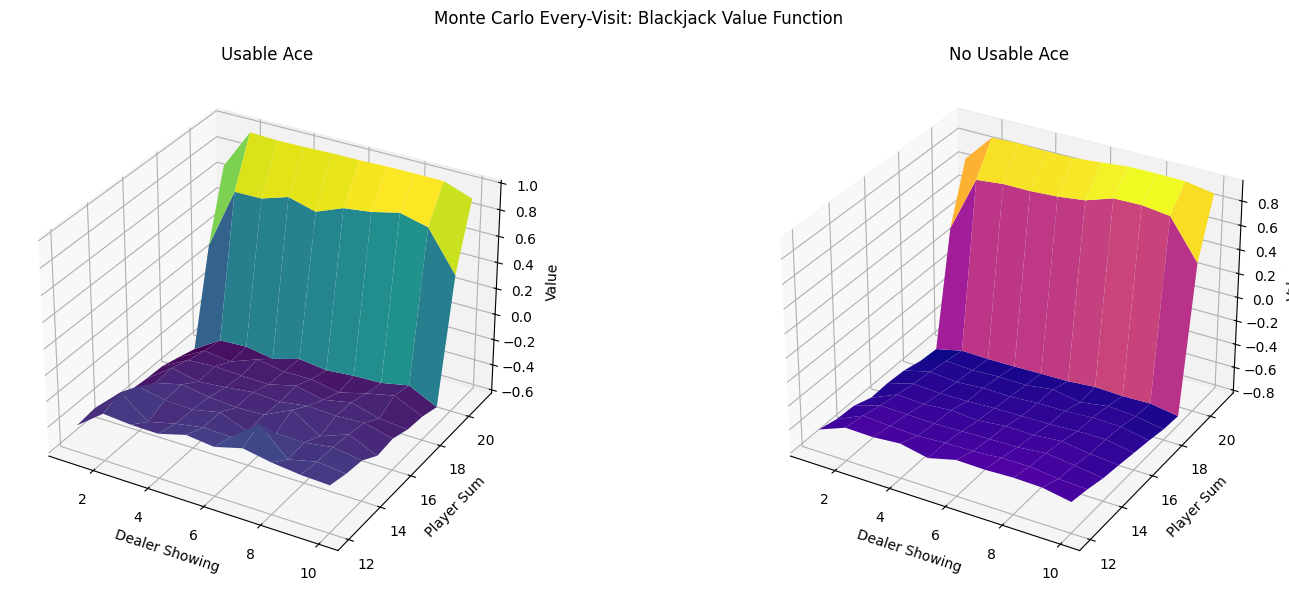

In [7]:
V = mc_prediction(policy, env, num_episodes=500000)
plot_value_function(V, title="Monte Carlo Every-Visit: Blackjack Value Function")

<h2>MC Action estimates</h2>
<h4>Does not require model. Estimate $q_{*}$. Start from a random state, take an action a. For this to work requires all state action pairs are explored. A method to guarantee exploration of all state-action pairs in an env is exploring starts</h4>

In [ ]:
!pip install 'gymnasium[all]'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# --- Gridworld Setup ---
grid_size = (4, 4)
terminal_states = [(0, 0), (3, 3)]
actions = ['U', 'D', 'L', 'R']
action_map = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
gamma = 1.0

# --- Step Function ---
def step(state, action):
    if state in terminal_states:
        return state, 0
    move = action_map[action]
    next_state = (
        max(0, min(state[0] + move[0], grid_size[0] - 1)),
        max(0, min(state[1] + move[1], grid_size[1] - 1))
    )
    reward = -1
    return next_state, reward

# --- Exploring Starts: Random State & Action ---
def generate_episode(Q):
    start_states = [(i, j) for i in range(grid_size[0]) for j in range(grid_size[1]) if (i, j) not in terminal_states]
    state = random.choice(start_states)
    action = random.choice(actions)
    episode = [(state, action, 0)]  # initial (s, a, r)

    while True:
        next_state, reward = step(state, action)
        if next_state in terminal_states:
            episode.append((next_state, None, reward))
            break
        state = next_state
        action = max(Q[state], key=Q[state].get) if state in Q else random.choice(actions)
        episode.append((state, action, reward))
    return episode

# --- Monte Carlo Control with Exploring Starts ---
def mc_control_es(num_episodes=10000):
    Q = defaultdict(lambda: {a: 0.0 for a in actions})
    returns = defaultdict(list)
    policy = {}

    for _ in range(num_episodes):
        episode = generate_episode(Q)
        G = 0
        visited = set()
        for t in reversed(range(len(episode) - 1)):
            state, action, reward = episode[t]
            G = gamma * G + episode[t + 1][2]  # use next step's reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])
                policy[state] = max(Q[state], key=Q[state].get)
    return policy, Q

# Q-learning implementation
def q_learning(grid_size=(4, 4), alpha=0.1, gamma=1.0, epsilon=0.1, episodes=10000):
    Q = defaultdict(lambda: {a: 0.0 for a in actions})
    policy = {}

    for _ in range(episodes):
        state = random.choice([
            (i, j) for i in range(grid_size[0])
                   for j in range(grid_size[1])
                   if (i, j) not in terminal_states
        ])

        while state not in terminal_states:
            if random.random() < epsilon:
                action = random.choice(actions)
            else:
                action = max(Q[state], key=Q[state].get)

            next_state, reward = step(state, action)
            best_next_action = max(Q[next_state], key=Q[next_state].get)
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state

    for s in Q:
        policy[s] = max(Q[s], key=Q[s].get)

    return policy, Q

def plot_policy(policy):
    grid = np.full(grid_size, '', dtype=object)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            s = (i, j)
            grid[i, j] = policy.get(s, 'T' if s in terminal_states else '?')
    plt.figure(figsize=(6, 6))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            plt.text(j, grid_size[0] - 1 - i, grid[i, j], ha='center', va='center', fontsize=16)
    plt.xticks(np.arange(grid_size[1]))
    plt.yticks(np.arange(grid_size[0]))
    plt.grid(True)
    plt.title("Optimal Policy via MC Control (Exploring Starts)")
    plt.show()
    

In [ ]:
policy, Q = mc_control_es(num_episodes=10000)
plot_policy(policy)

In [ ]:
if __name__ == "__main__":
    print("Training Monte Carlo (Exploring Starts)...")
    mc_policy, _ = mc_control_es(num_episodes=10000)
    plot_policy(mc_policy, title="Monte Carlo Policy (Exploring Starts)")

    print("Training Q-learning...")
    ql_policy, _ = q_learning(episodes=10000)
    plot_policy(ql_policy, title="Q-learning Policy")

In [ ]:
Episode:
1. Observation = (13, 3, False) → Action = 'hit' → Reward = 0
2. Observation = (21, 3, False) → Action = 'stick' → Reward = +1
Final reward: +1 (player wins)

In [ ]:
# In a Colab cell (if not already installed)
!pip install gymnasium torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from torch.distributions import Categorical

# Define RNN policy network
class RNNPolicy(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=2):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, obs_seq, h=None):
        out, h = self.rnn(obs_seq, h)
        logits = self.fc(out)
        return logits, h

In [ ]:
def encode_obs(obs):
    player_sum, dealer_card, usable_ace = obs
    return torch.tensor([
        player_sum / 32.0,
        dealer_card / 11.0,
        float(usable_ace)
    ], dtype=torch.float32)

In [ ]:
def run_episode(env, policy_net):
    obs_seq = []
    log_probs = []
    rewards = []

    state, _ = env.reset()
    h = None

    for _ in range(20):  # max steps
        obs = encode_obs(state)
        obs_seq.append(obs)

        obs_tensor = torch.stack(obs_seq).unsqueeze(0)  # (1, T, 3)
        logits, h = policy_net(obs_tensor, h)
        probs = torch.softmax(logits[0, -1], dim=-1)
        dist = Categorical(probs)
        action = dist.sample()

        log_probs.append(dist.log_prob(action))

        state, reward, done, _, _ = env.step(action.item())
        rewards.append(reward)

        if done:
            break

    return log_probs, rewards

In [ ]:
def train_rnn(env, episodes=1000, lr=1e-2):
    policy_net = RNNPolicy()
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    for ep in range(episodes):
        log_probs, rewards = run_episode(env, policy_net)

        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + 0.99 * G
            returns.insert(0, G)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        loss = -torch.stack(log_probs) * returns
        loss = loss.sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (ep + 1) % 100 == 0:
            print(f"Episode {ep+1}, return = {sum(rewards)}")

    return policy_net

In [ ]:
env = gym.make("Blackjack-v1", sab=True)
trained_policy = train_rnn(env, episodes=1000)

In [ ]:
trained_policy